Lab 1
================================================================================
El Niño & La Niña Occurences \
Keagan DeLong \
Block 1

#Introduction

We will be eploring the data associated with El Niño occurences and figures and observations that were made it the discussion paper. All of the datasets referenced in the discussion paper have been analyzed by our 'toolkit' we learned in class.



#Background

##Objectives
Lam et al. discusses how the  El Niño Southern Oscillation (ENSO) is a driver in climactic variables that have global impacts on public health. The paper aimed to establish a relationship between the number of people effected by disaster (PAD) and the ENSO. The annual numbers used in the paper are listed between 1964-2017. 

##Methods

The paper used three different data sets: Oceanic Niño Index (ONI), Multi-variate ENSO Index (MEI), and EMDAT which is the database on natura and technological disasters. The EMDAT dataset was augmented by population data from The World Bank to produce the PAD dataset.

##Results

The authors found that global drought-related PAD rates increase sharpley during El Niño years. 95% of PAD were caused by floods, droughts or storms, where 75% of these people reside in Asia. 

#Methods
##Data

###ONI Data

In [1]:
oni.url <- "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
oni.name <- tail(unlist(strsplit(oni.url, "/")), n=1)
oni.file <- paste("/tmp/", oni.name, sep="")
download.file(oni.url, oni.file, method = 'auto')

In [2]:
oni.df <- read.table(oni.file, header = TRUE)

In [3]:
oni.filt <- subset(oni.df, SEAS == 'DJF')
oni.filt <- subset(oni.filt, YR > 1963 & YR < 2018)

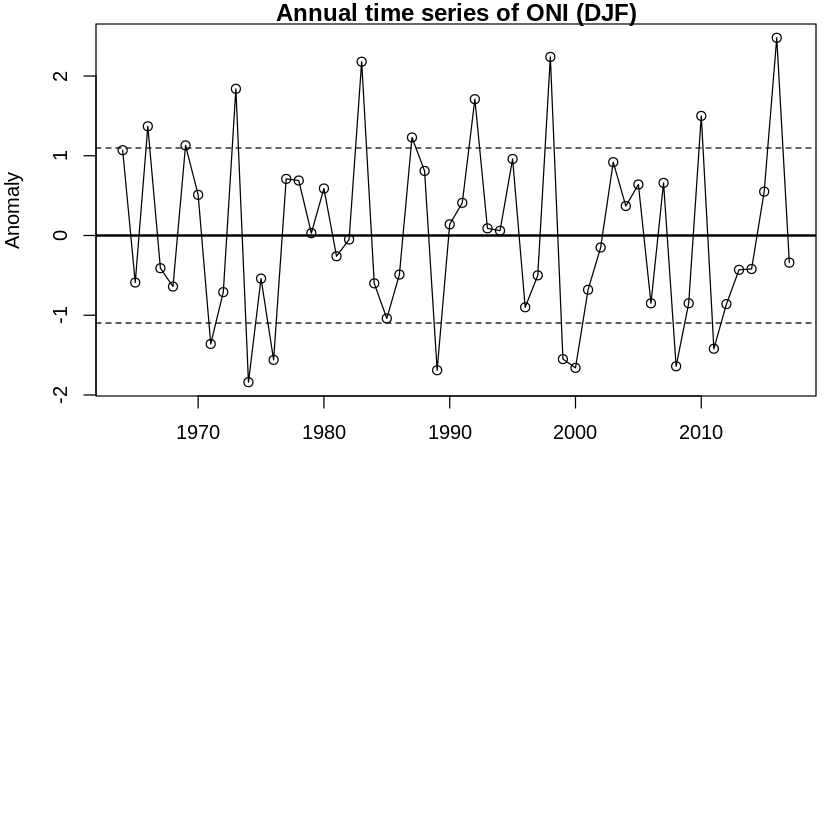

In [4]:
par(mar=c(1,4,1,1))
par(fig=c(0.0,1,0.5,1))
plot(
  oni.filt$YR, oni.filt$ANOM, 
  main = "Annual time series of ONI (DJF)", 
  type="o",
  xlab="Year",
  ylab="Anomaly")
abline(h=0, lty=1, lwd=2)
abline(h=sd(oni.filt$ANOM), lty=2)
abline(h=-1*sd(oni.filt$ANOM), lty=2)

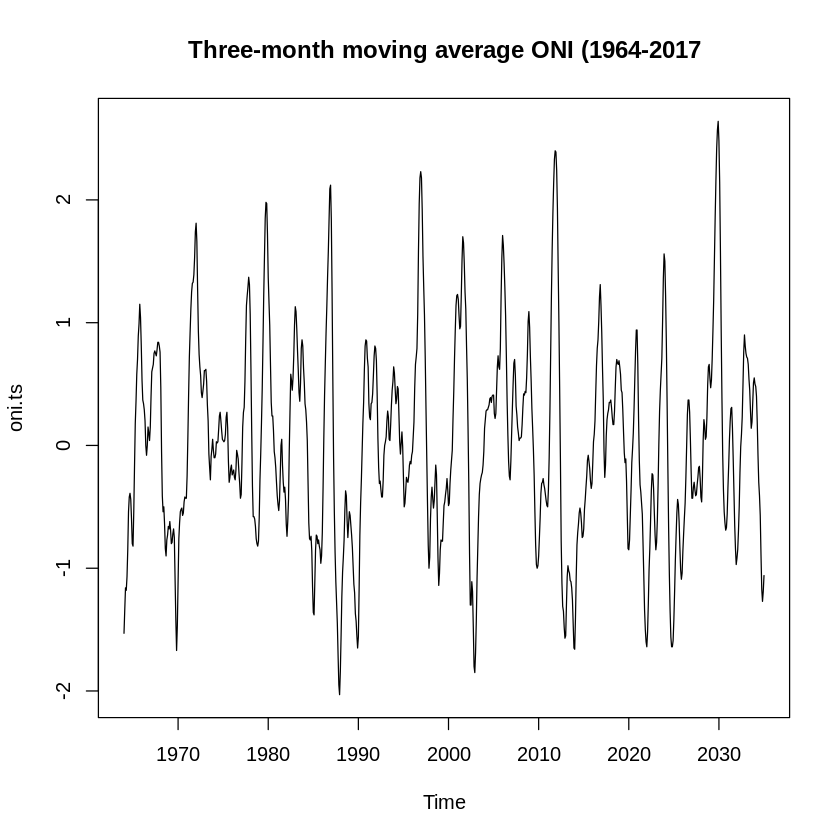

In [5]:
oni.ts <- ts(oni.df$ANOM, start = c(1964, 1), frequency = 12)
plot(oni.ts, main="Three-month moving average ONI (1964-2017")

###MEI Data

In [6]:
mei.url <- "https://psl.noaa.gov/enso/mei.old/table.html"
mei.name <- tail(unlist(strsplit(mei.url, "/")), n=1)
mei.file <- paste("/tmp/", mei.name, sep="")
download.file(mei.url, mei.file, method = 'auto')

In [7]:
a <- readLines(mei.file)
for (my.line in a){
  a <- grep("^YEAR.*", my.line)
  if (length(a) > 0) {
    my.cols <- unlist(strsplit(my.line, "\\s+"))
  }
}

In [8]:
n.cols <- length(my.cols)
mei.df <- data.frame(matrix(ncol = n.cols, nrow = 0))
colnames(mei.df) <- my.cols 

In [9]:
a <- readLines(mei.file)
for (mei.line in a){
  a <- grep("^[0-9].*", mei.line)
  if (length(a) > 0) {
    mei.data <- unlist(strsplit(mei.line, "\\s+"))
    num.data <- length(mei.data)
    if (num.data == n.cols) {
      mei.values <- c()
      for (d in mei.data) {
        mei.values <- append(mei.values, as.numeric(d))
      }
      mei.df[nrow(mei.df)+1,] = mei.values
    }
  }
}

In [10]:
mei.ts <- ts(as.vector(t(mei.df[,2:length(my.cols)])), start = c(1950, 1), frequency = 12)

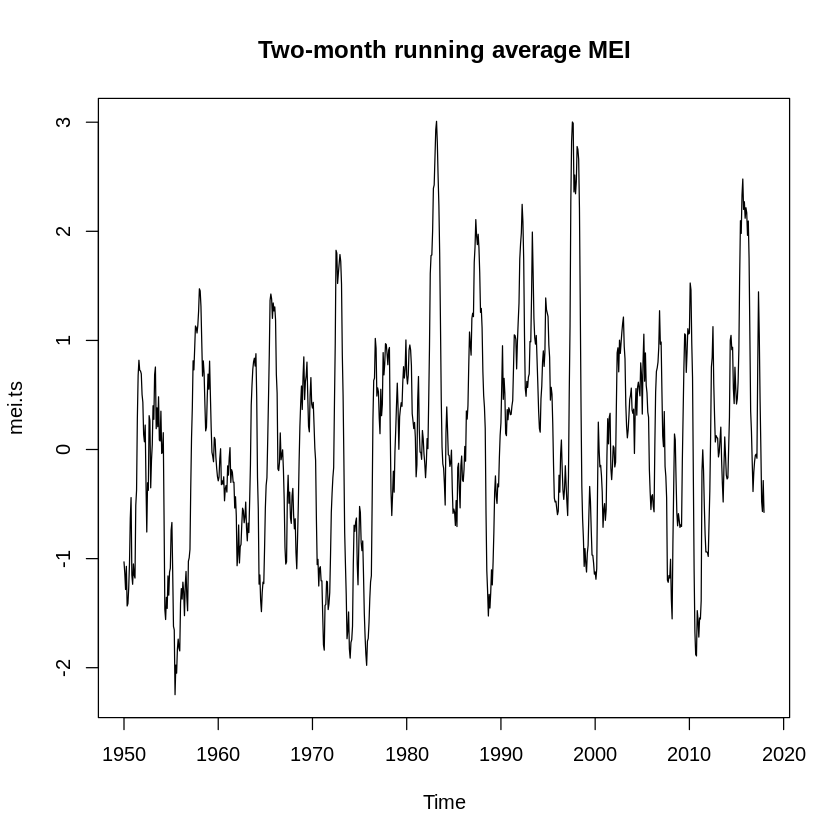

In [11]:
plot(mei.ts, main = "Two-month running average MEI")

###PAD Data

In [12]:
pad.file <- "emdat_public.csv"
pad.df.all <- read.csv(pad.file, header=TRUE, skip=6)

In [13]:
cols.interest <- c("Country", "ISO", "Start.Year", "Start.Month", 
                   "End.Year", "End.Month", "Total.Deaths", "Declaration", 
                   "OFDA.Response", "Total.Affected")
pad.df <- pad.df.all[cols.interest]

In [14]:
wbank.url <- "http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv"
wbank.name <- "world_bank.zip"
wbank.file <- paste("/tmp/", wbank.name, sep="")
download.file(wbank.url, wbank.file)

In [15]:
unzip(zipfile = wbank.file, exdir = "/tmp")

In [16]:
my.file <- ""
for (tmp.file in list.files("/tmp")){
  a <- grep("^API_SP.POP.TOTL.*csv", tmp.file)
  if (length(a) > 0) {
    my.file <- tmp.file
  }
}

In [17]:
wb.file <- paste("/tmp/", my.file, sep="")

In [18]:
wb.df <- read.csv(wb.file, header = TRUE, skip = 4)
df <- wb.df[1:(length(wb.df)-2)]

In [19]:
for (i in 1:nrow(pad.df)) {
  # Remember i is the row index in pad.df
  tmp.iso <- pad.df[i, ][['ISO']]
  tmp.year <- pad.df[i, ][['Start.Year']]
  tmp.col <- paste("X", tmp.year, sep="")
  # Match returns "NA" if no match
  a <- match(tmp.iso, wb.df$Country.Code)
  if (!is.na(a)) {
    tmp.pop <- wb.df[,tmp.col][a]
    # We can create new dataframe columns on the fly
    pad.df[i, 'POP'] = tmp.pop
    #print(c(tmp.iso, tmp.year, tmp.pop))
  } else {
    # Make sure to assign missing values, too!
    pad.df[i, 'POP'] = NA
  }
}

In [20]:
#total population of countries impacted by disaster from 1964-2017
pad.tot <- c()
for (years in unique(pad.df$Start.Year)) {
  my.pad <- subset(pad.df, Start.Year == years)
  pad.all <- 0
  for (i in 1:nrow(my.pad)){
    if (!is.na(my.pad$Total.Affected[i]) & !is.na(my.pad$POP[i])){
      my.ta <- my.pad$Total.Affected[i]
      pad.all <- pad.all + my.ta
    }
  }
  pad.pop <- 0
  for (my.iso in unique(my.pad$ISO)){
    a <- match(my.iso, my.pad$ISO)
    temp.pop <- my.pad$POP[a]
    if (!is.na(temp.pop)){
      pad.pop <- pad.pop + temp.pop
    }
  }
  pad.final<- pad.all/pad.pop*1000
  pad.tot <- c(pad.tot, pad.final)
}
pad.years <- c(1964:2017)
pad.all.df <- data.frame(as.numeric(pad.years), pad.tot)
pad.ts <- ts(pad.all.df$pad.tot, start=1964, frequency = 12)

###Other Dataset that may exhibit El Niño Patterns: North Atlantic Oscillation (NAO)

In [21]:
#Download the NAO dataset in .csv format and read into a dataframe
nao.url <- "https://www.ncdc.noaa.gov/teleconnections/nao/data.csv"
nao.name <- tail(unlist(strsplit(nao.url, "/")), n=1)
nao.file <- paste("/tmp/", nao.name, sep="")
download.file(nao.url, nao.file, method = 'auto')
nao.df <- read.csv(nao.file, header=T)

#Analysis

###Package used in Analysis:

In [22]:
install.packages('tswge')
library(tswge)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



##ONI Analysis

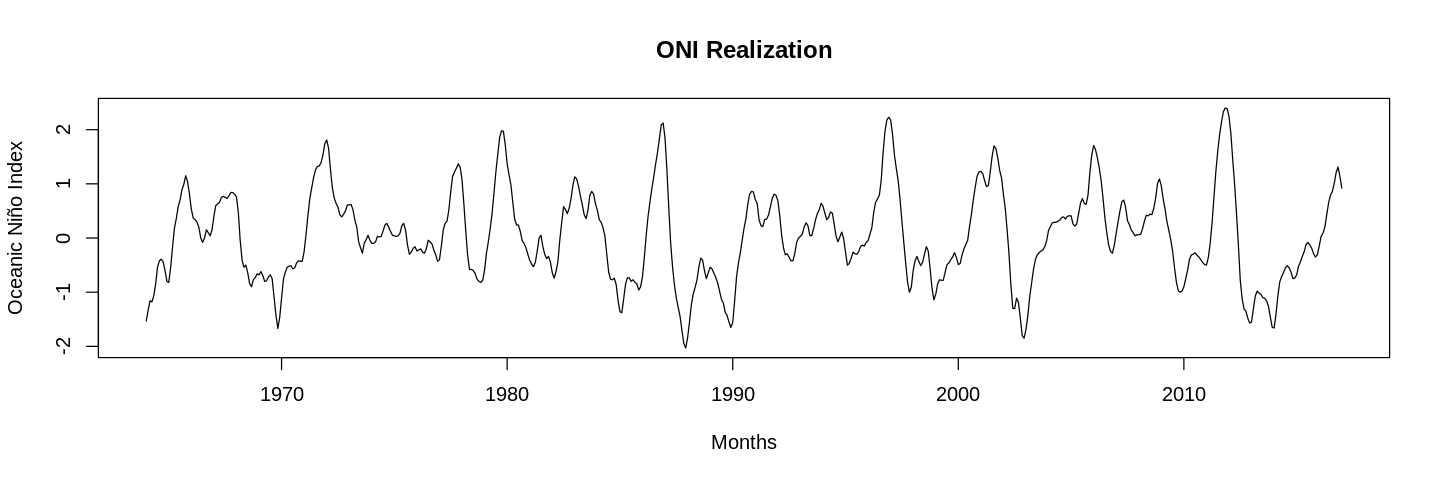

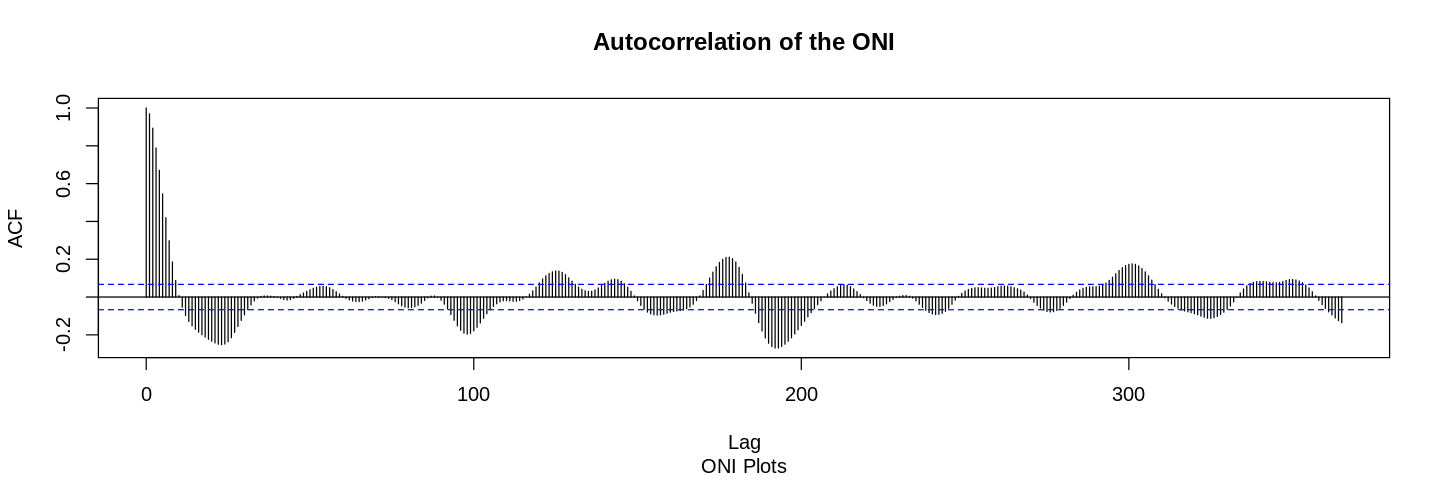

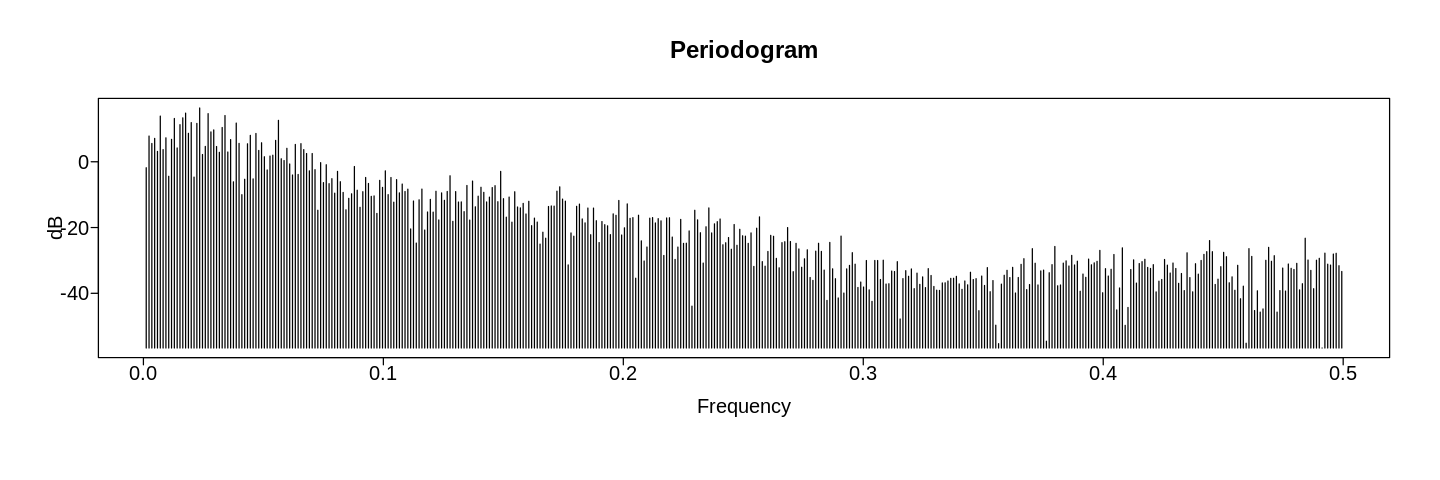

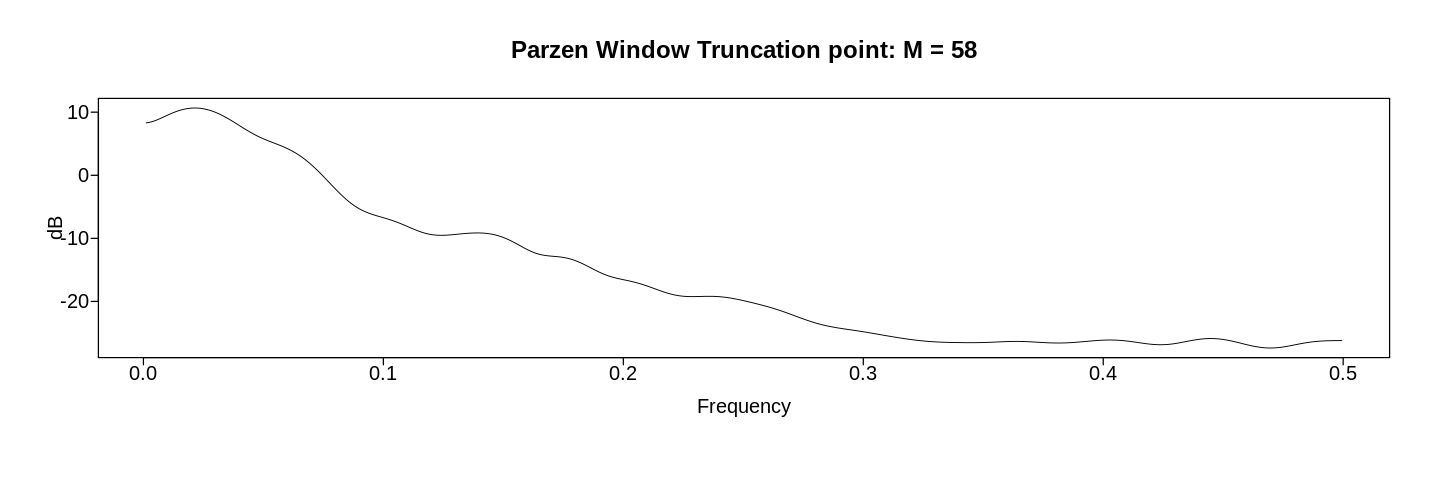

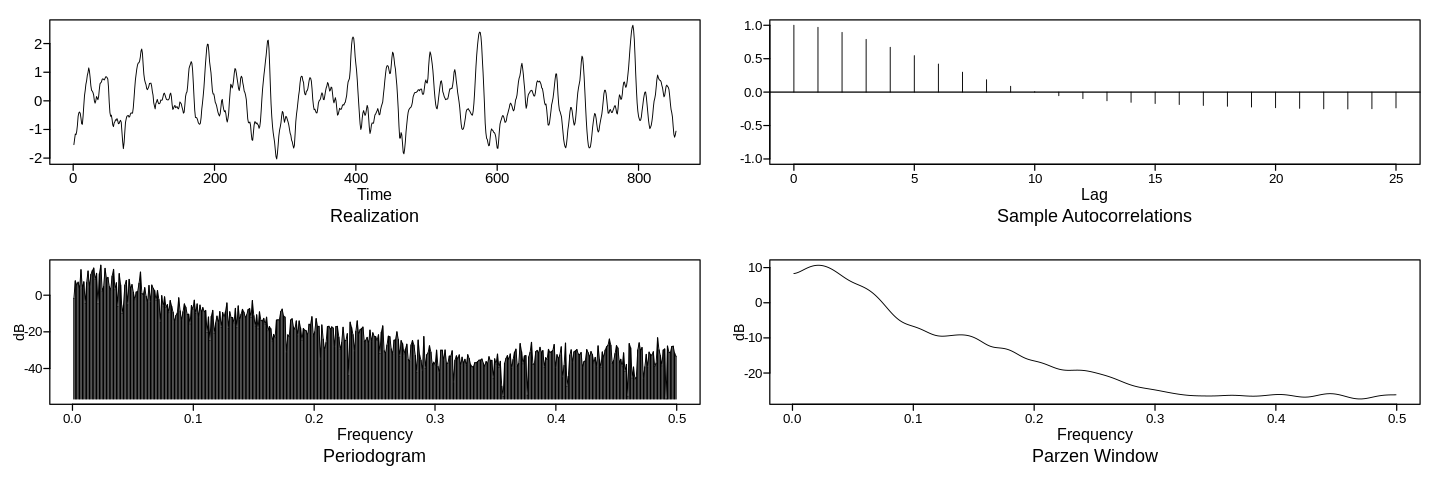

In [23]:
#create an object specifically for analysis
oni.analysis <- ts(oni.df$ANOM, start=1964,, end = 2017, frequency = 12)
options(repr.plot.width = 12, repr.plot.height = 4)
plot(oni.analysis,
  ylab = 'Oceanic Niño Index',
  xlab = 'Months',
  main = 'ONI Realization',
  type = 'l',
  lty = 1)
oni.acf <- acf(oni.df$ANOM, main = 'Autocorrelation of the ONI', sub = 'ONI Plots', lag.max = 365)
oni.period <- period.wge(oni.df$ANOM)
oni.par <- parzen.wge(oni.df$ANOM)
oni.plotts.sample <- plotts.sample.wge(oni.ts)

In [24]:
oni.freq <- period.wge(oni.analysis, plot = F)$freq[which.max(oni.period$pgram)]
cat("Frequency:",oni.freq,"Period:", 1/oni.freq)

Frequency: 0.03139717 Period: 31.85

##MEI Analysis


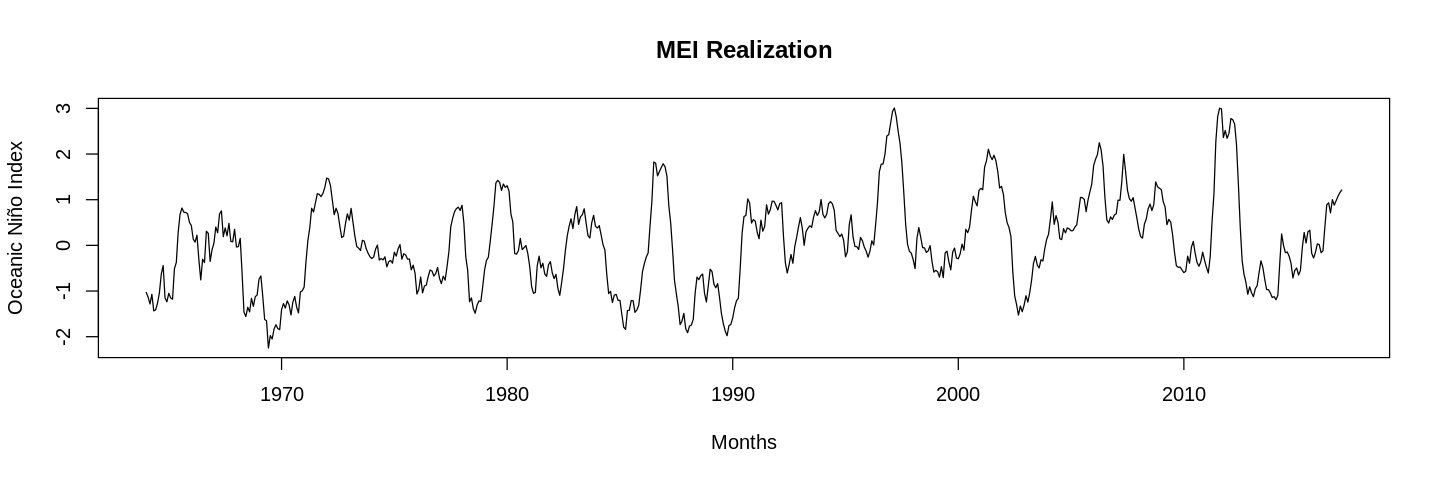

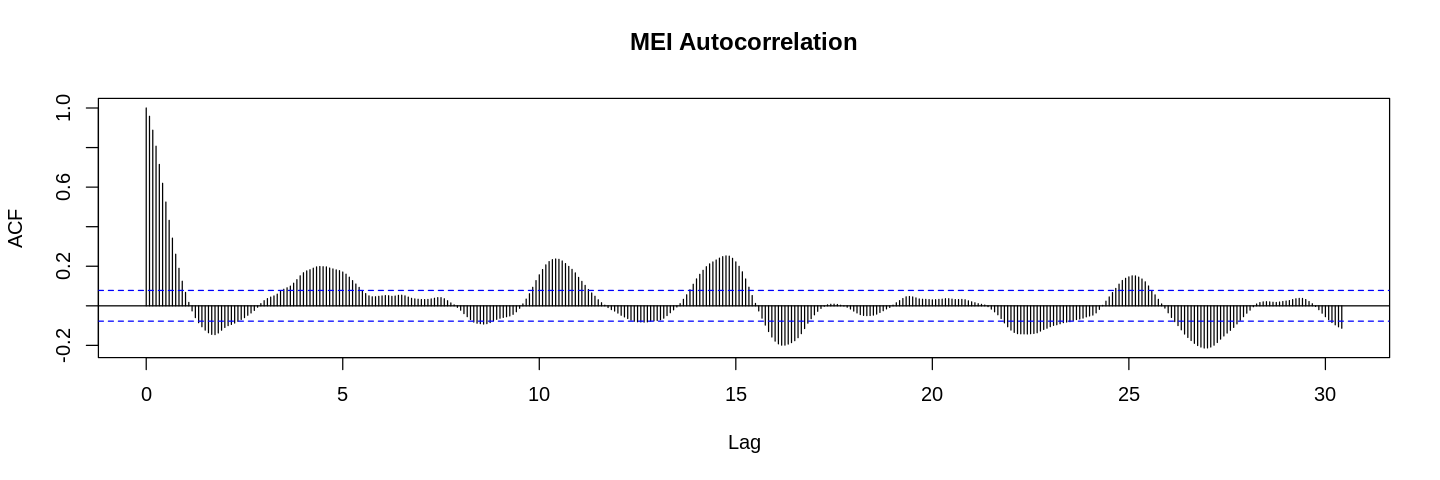

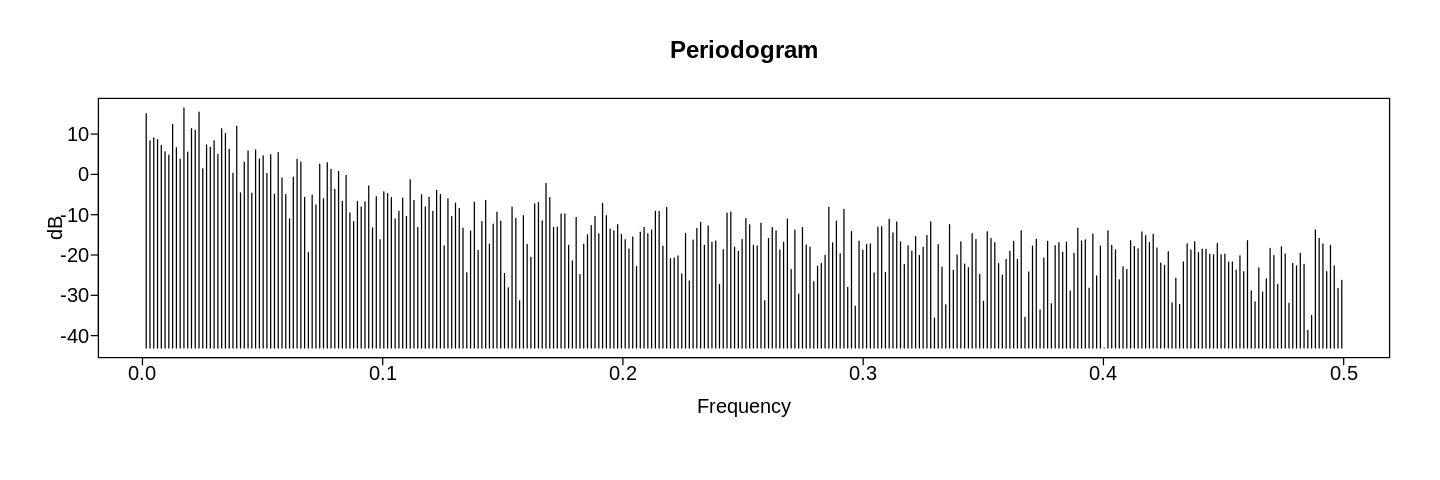

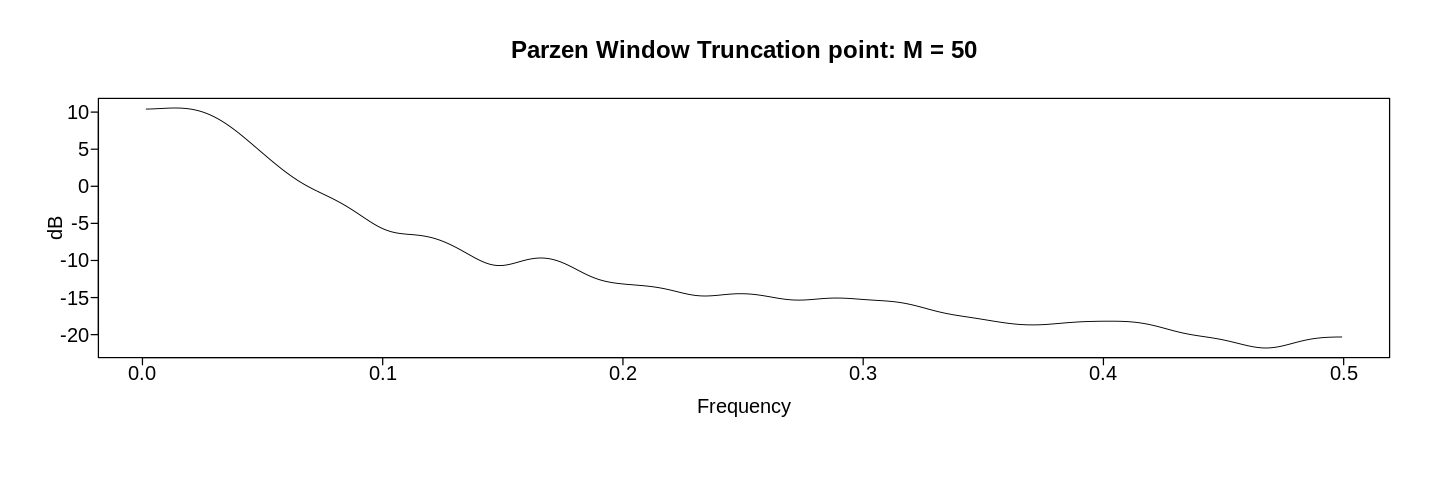

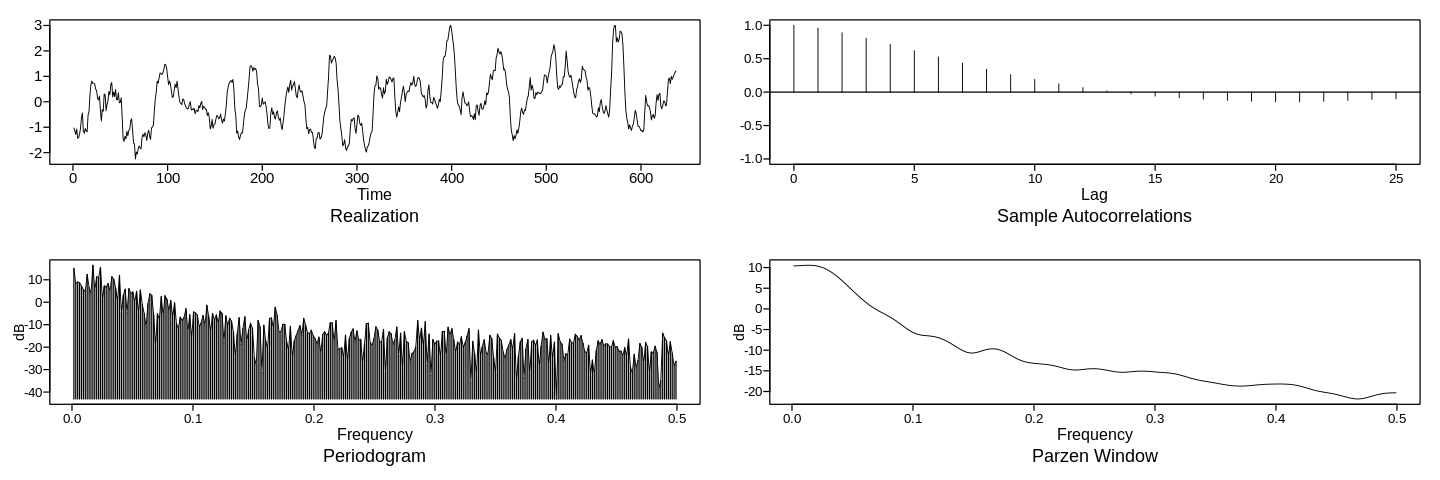

In [25]:
#Object specifically for analysis based on the the data created
mei.analysis <- ts(as.vector(t(mei.df[,2:length(my.cols)])), start = c(1964, 1), end = c(2017,1), frequency = 12)
options(repr.plot.width = 12, repr.plot.height = 4)
plot(mei.analysis,
  ylab = 'Oceanic Niño Index',
  xlab = 'Months',
  main = 'MEI Realization',
  type = 'l',
  lty = 1)
acf(mei.analysis, type = 'correlation', main = 'MEI Autocorrelation', lag.max = 365)
mei.period <- period.wge(mei.analysis)
mei.par <- parzen.wge(mei.analysis)
mei.plotts <- plotts.sample.wge(mei.analysis)


In [26]:
mei.freq <- period.wge(mei.analysis, plot = F)$freq[which.max(mei.period$pgram)]
cat("Frequency:",mei.freq,"Period:", 1/mei.freq)

Frequency: 0.01726845 Period: 57.90909

##PAD Analysis

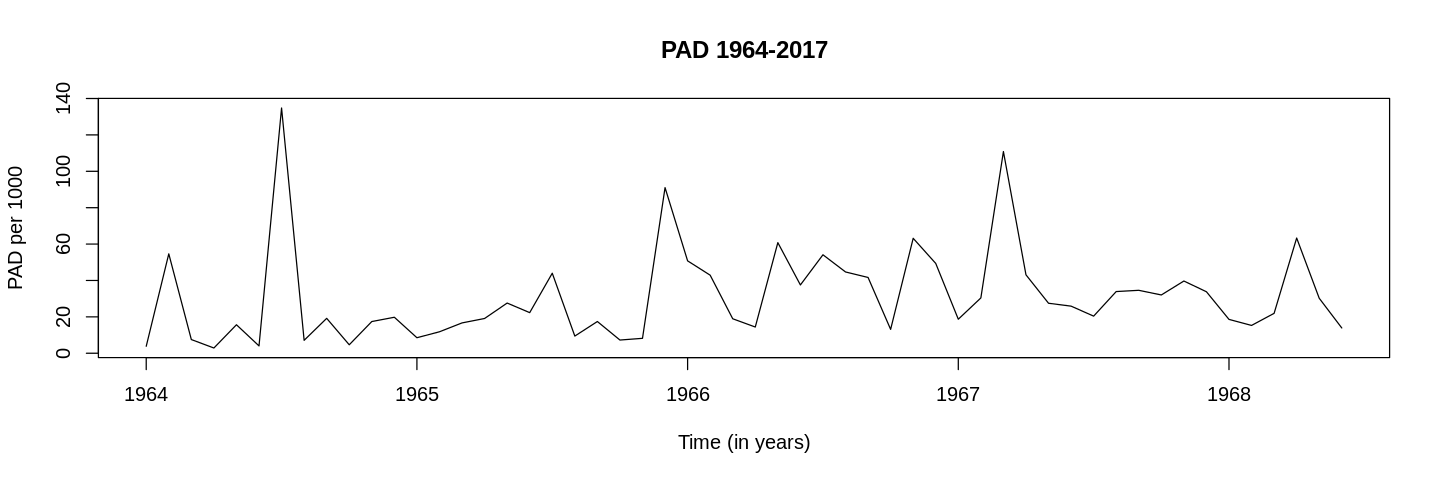

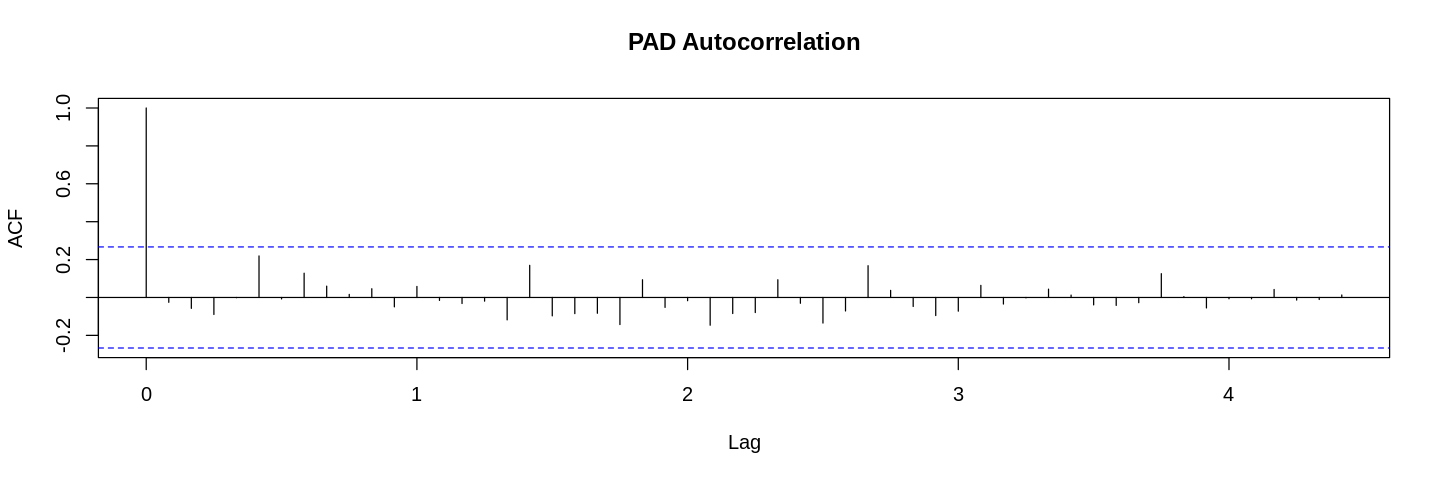

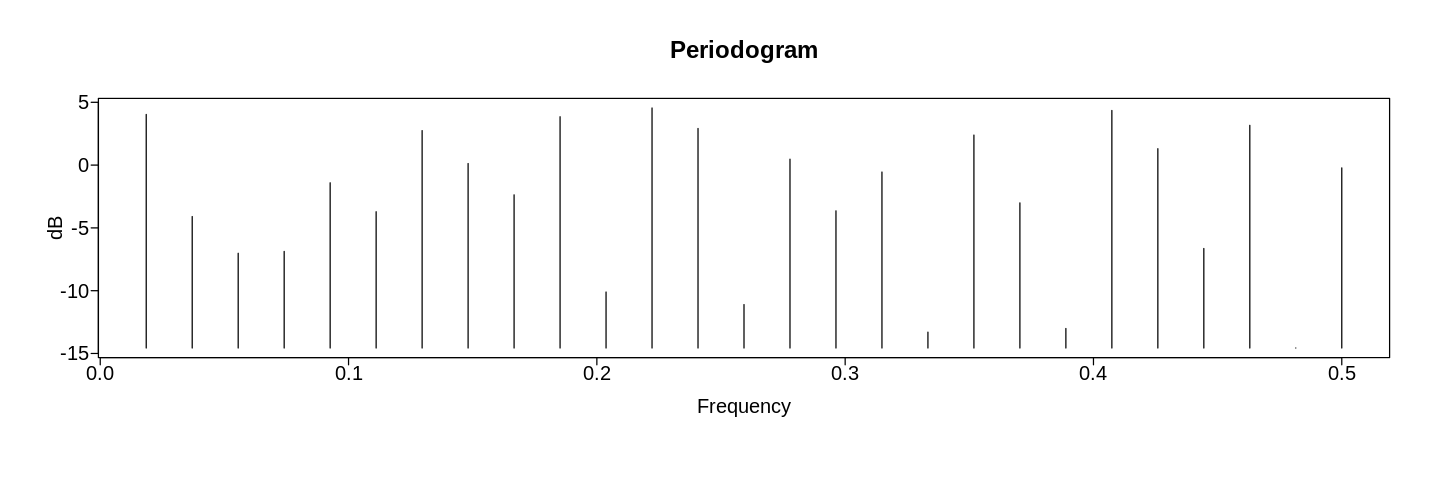

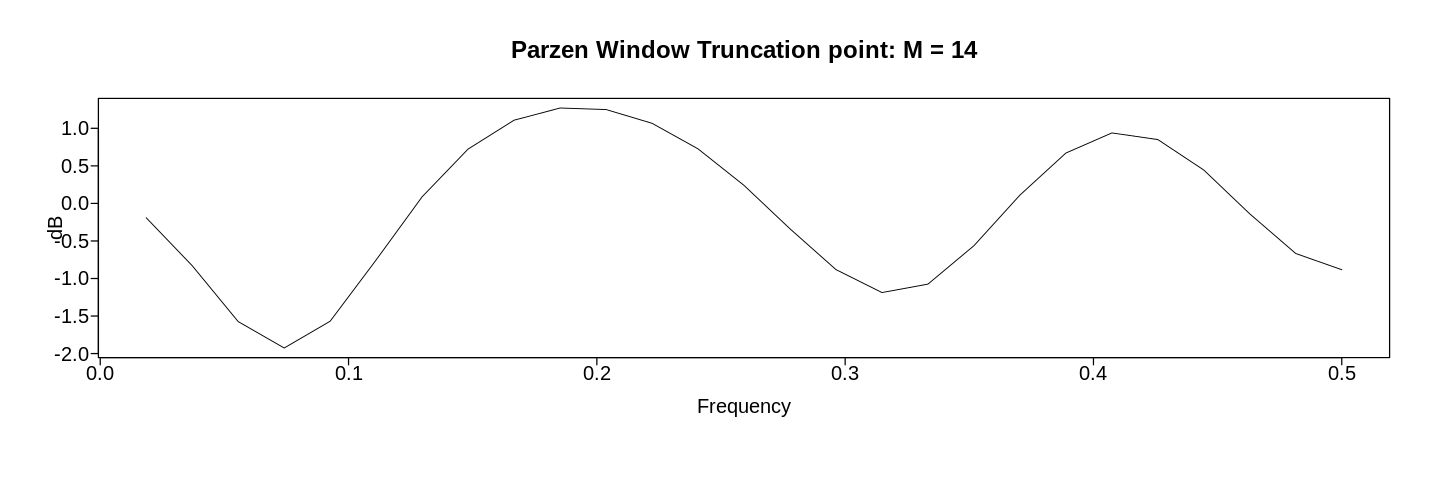

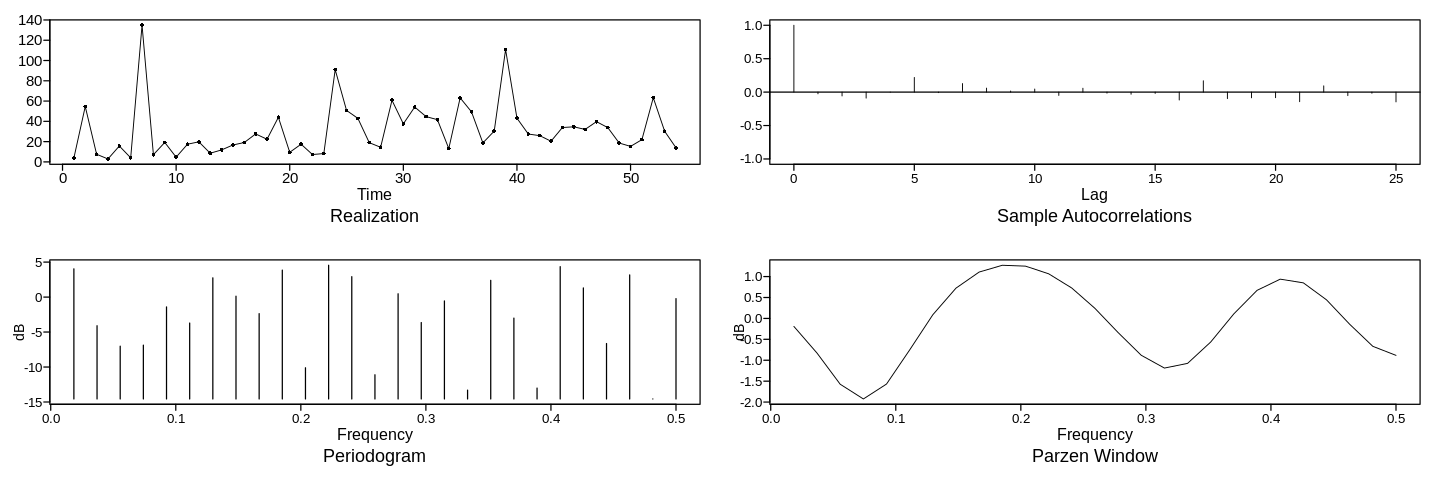

In [27]:
pad.analysis <- ts(pad.all.df$pad.tot, start=1964, frequency = 12)
options(repr.plot.width = 12, repr.plot.height = 4)
plot(pad.analysis,
  ylab = 'PAD per 1000',
  xlab = 'Time (in years)',
  main = 'PAD 1964-2017',
  type = 'l',
  lty = 1)
acf(pad.analysis, type = 'correlation', main = 'PAD Autocorrelation', lag.max = 365)
pad.period <- period.wge(pad.analysis)
pad.par <- parzen.wge(pad.analysis)
pad.plotts <- plotts.sample.wge(pad.analysis)

In [28]:
pad.freq <- period.wge(pad.analysis, plot = F)$freq[which.max(pad.period$pgram)]
cat("Frequency:",pad.freq,"Period:", 1/pad.freq)

Frequency: 0.2222222 Period: 4.5

##TNA Analysis

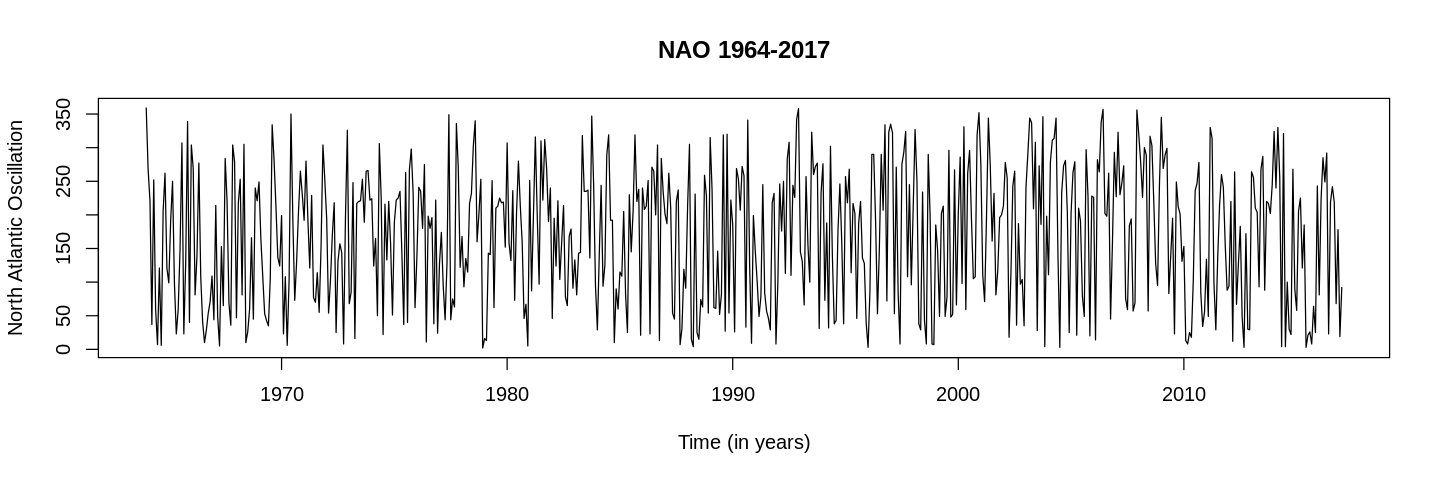

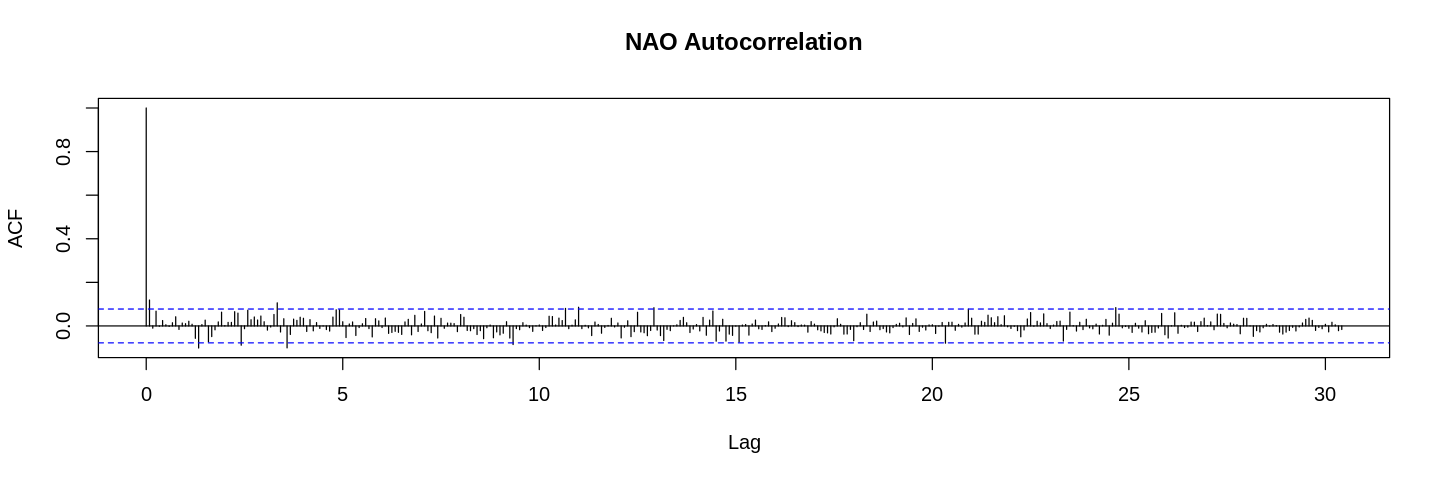

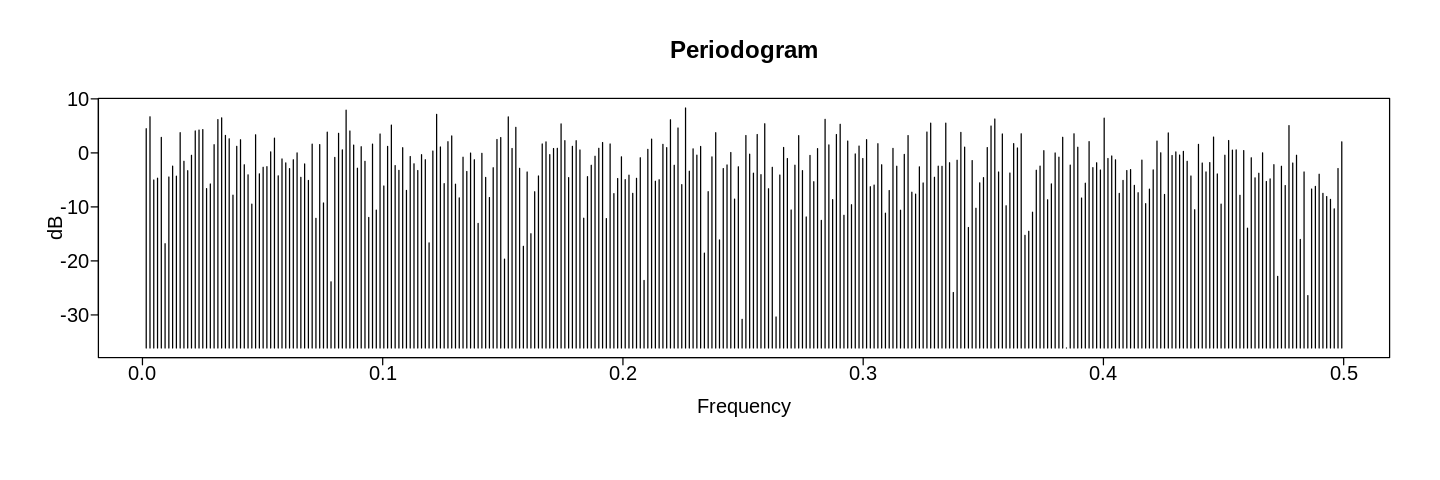

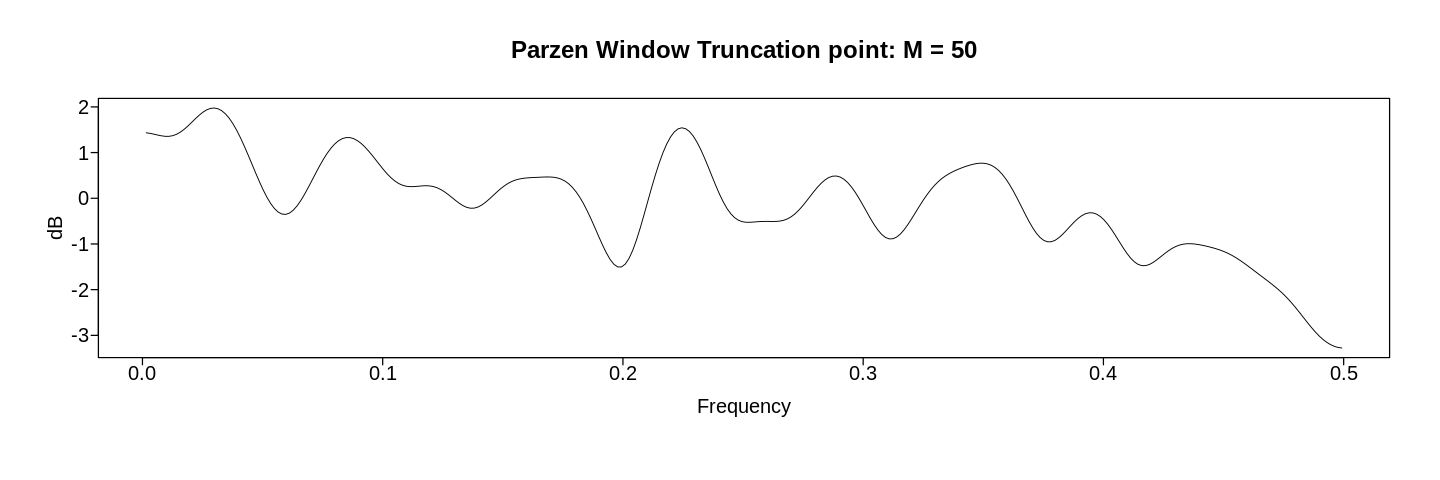

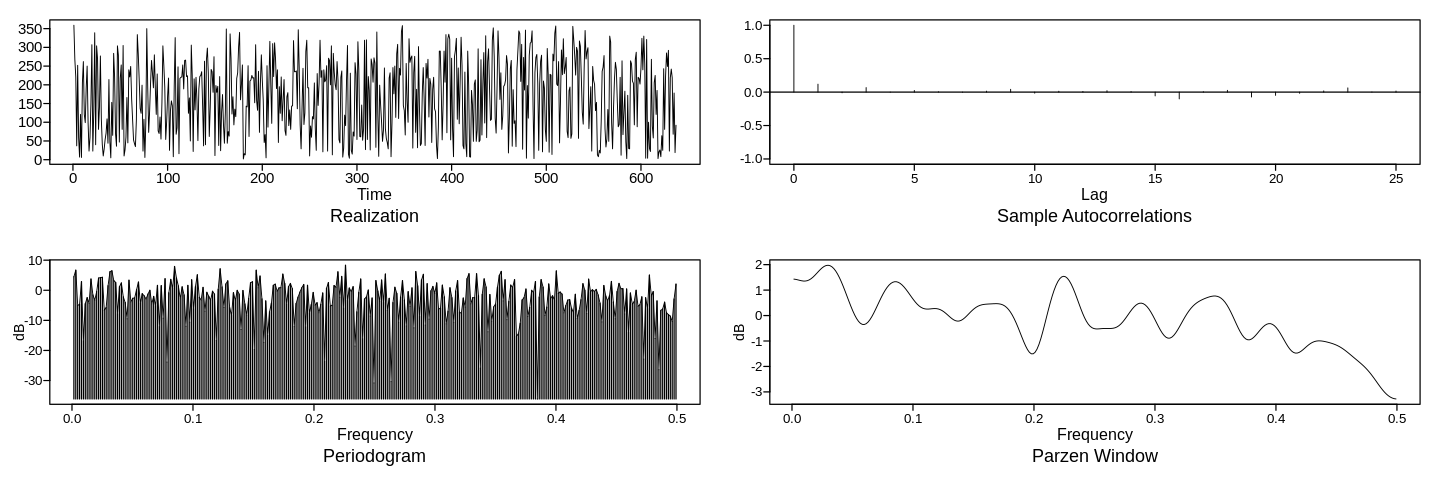

In [29]:
nao.analysis <- ts(nao.df, start=1964, end = 2017, frequency = 12)
options(repr.plot.width = 12, repr.plot.height = 4)
plot(nao.analysis,
  ylab = 'North Atlantic Oscillation',
  xlab = 'Time (in years)',
  main = 'NAO 1964-2017',
  type = 'l',
  lty = 1)
acf(nao.analysis, type = 'correlation', main = 'NAO Autocorrelation', lag.max = 365)
nao.period <- period.wge(nao.analysis)
nao.par <- parzen.wge(nao.analysis)
nao.plotts <- plotts.sample.wge(nao.analysis)

In [30]:
nao.freq <- period.wge(nao.analysis, plot = F)$freq[which.max(nao.period$pgram)]
cat("Frequency:",nao.freq,"Period:", 1/nao.freq)

Frequency: 0.2260597 Period: 4.423611

##Years of El Nino

###Time series of the El Nino Years

In [31]:
nino.df <- oni.df[which(oni.df$YR > 1964 & oni.df$YR < 2018),] #filter between the years interested
nino.df$criteria <- nino.df$ANOM > 0.5 #identify the years that could be considered an El Nino event
nino.df$consecutive <- sequence(rle(as.character(nino.df$criteria))$lengths) #identify the consective years of El Nino events
nino.years <- nino.df$YR[which(nino.df$criteria == T & nino.df$consecutive ==5)]

nino.df$ninoyear <- 0 #identifying non-nino years
nino.df$ninoyear[which(nino.df$YR %in% nino.years)] <- 1 #nino years that match the criterion

nino.ts <- ts(nino.df$ninoyear, start = c(1964,1), end = c(2017,1), frequency = 12)

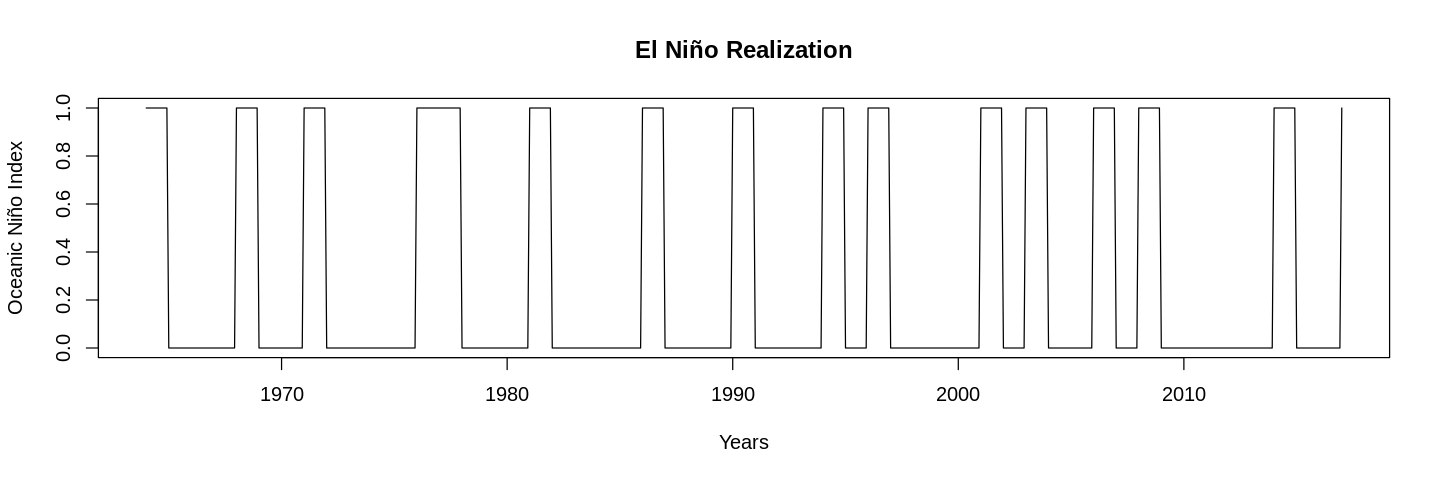

Warning message in period.wge(nino.df$ninoyear):
“NaNs produced”


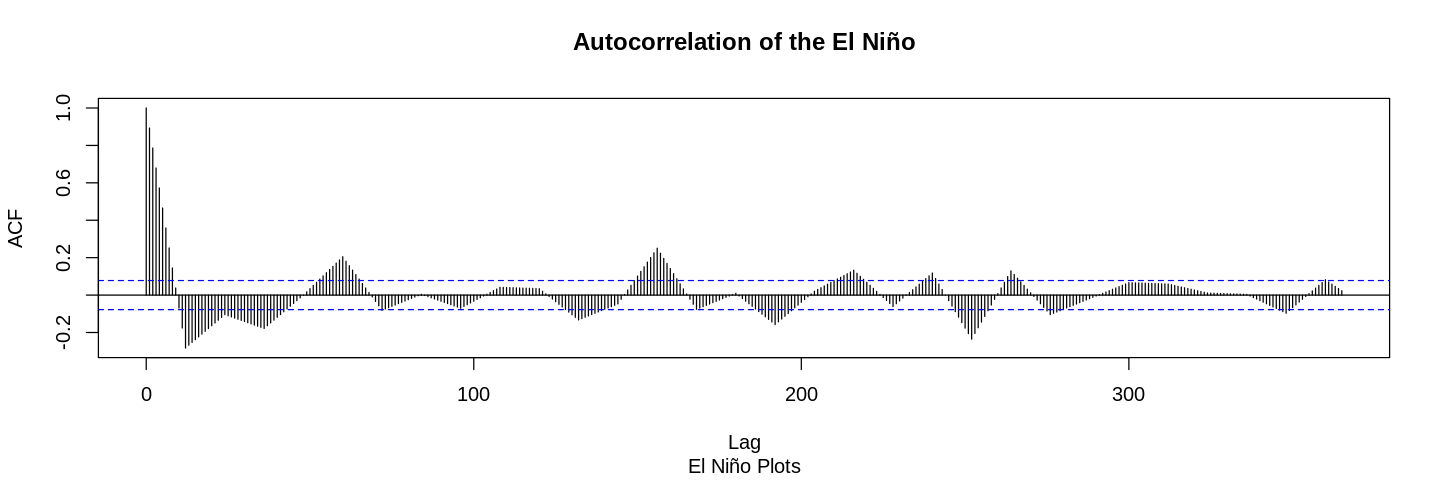

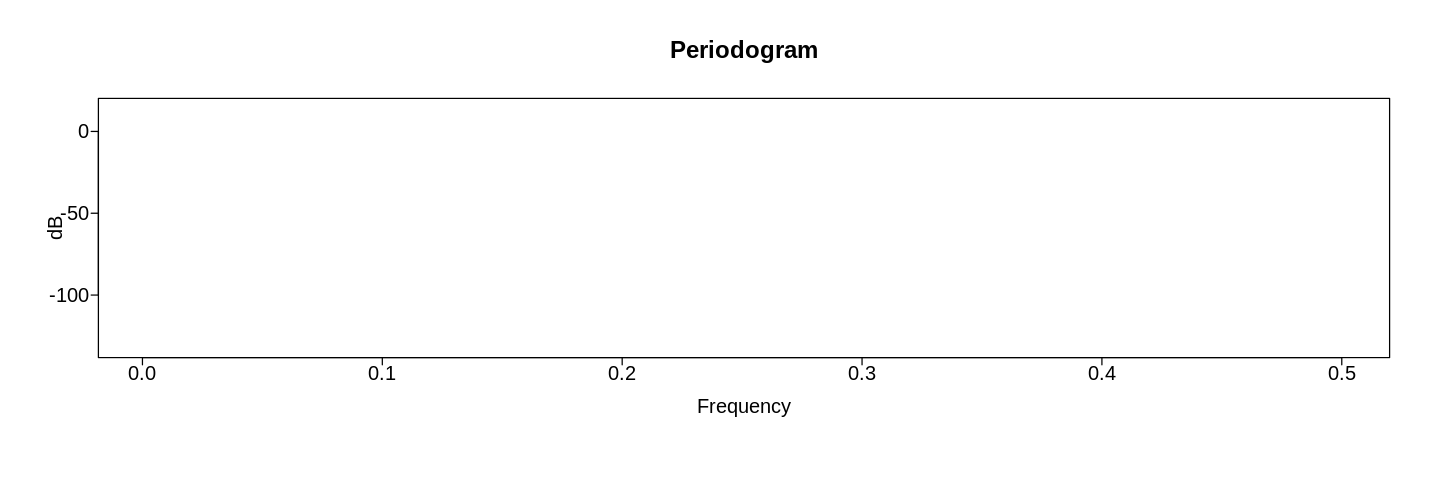

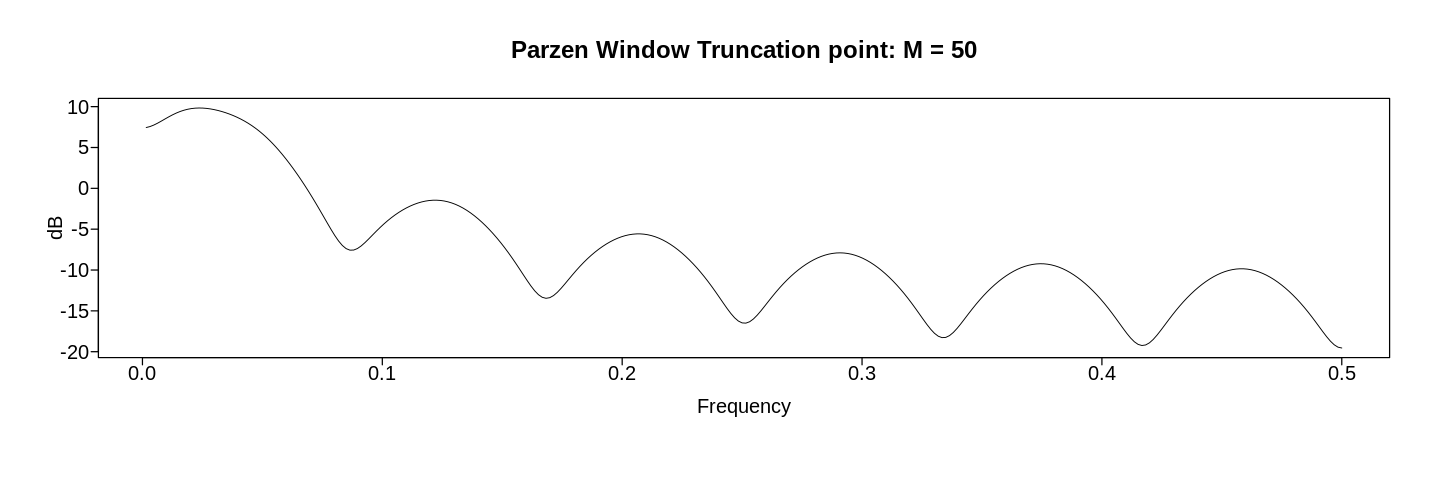

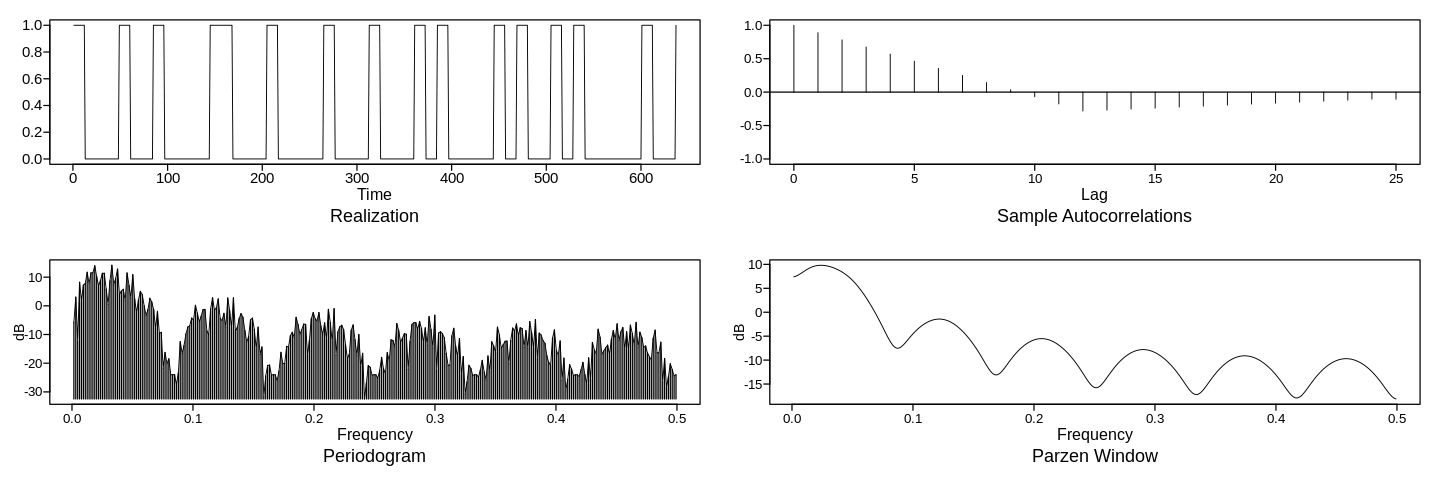

In [32]:
options(repr.plot.width = 12, repr.plot.height = 4)
plot(nino.ts,
  ylab = 'Oceanic Niño Index',
  xlab = 'Years',
  main = 'El Niño Realization',
  type = 'l',
  lty = 1)
nino.acf <- acf(nino.df$ninoyear, main = 'Autocorrelation of the El Niño', sub = 'El Niño Plots', lag.max = 365)
nino.period <- period.wge(nino.df$ninoyear)
nino.par <- parzen.wge(nino.df$ninoyear)
nino.plotts.sample <- plotts.sample.wge(nino.ts)

In [33]:
nino.freq <- period.wge(nino.ts, plot = F)$freq[which.max(nino.period$pgram)]
cat("Frequency:",nino.freq,"Period:", 1/nino.freq)

Frequency: 0.03296703 Period: 30.33333

##Plot From Lam Et Al.

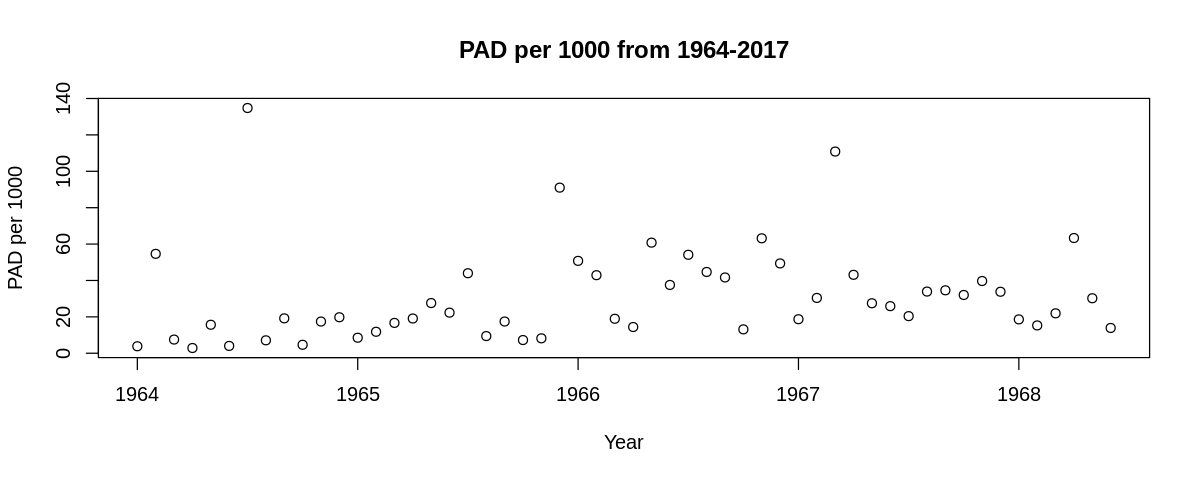

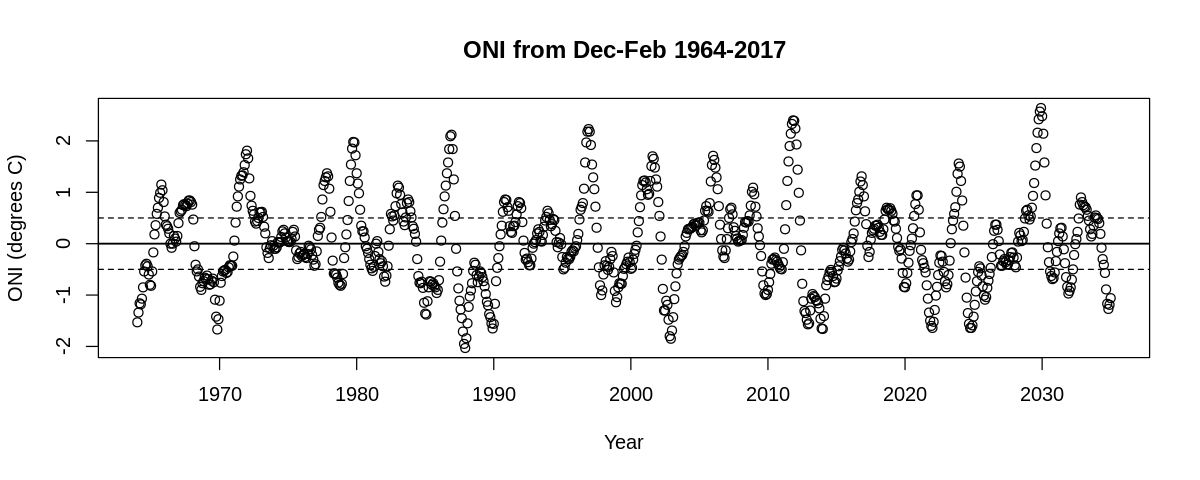

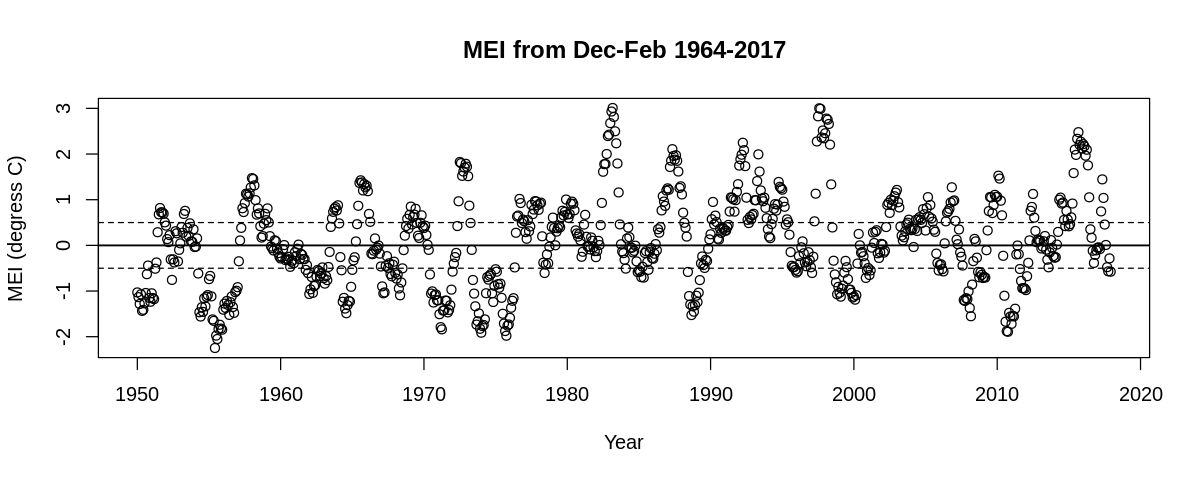

In [34]:
options(repr.plot.width = 10, repr.plot.height = 4)

plot(pad.analysis,
  xlab = 'Year',
  ylab = 'PAD per 1000',
  main = 'PAD per 1000 from 1964-2017',
  type = 'p'
  )
options(repr.plot.width = 10, repr.plot.height = 4)
  plot(oni.ts,
  xlab = 'Year',
  ylab = 'ONI (degrees C)',
  main='ONI from Dec-Feb 1964-2017',
  type = 'p'
  )
abline(h=0, lwd = 1.5)
abline(h = 0.5, lty = 2)
abline(h = -0.5, lty = 2)

options(repr.plot.width = 10, repr.plot.height = 4)
plot(mei.ts,
xlab = 'Year',
ylab = 'MEI (degress C)',
main = 'MEI from Dec-Feb 1964-2017',
type = 'p'
)
abline(h=0, lwd = 1.5)
abline(h = 0.5, lty = 2)
abline(h = -0.5, lty = 2)

##Discussion & Conclusion

  In the lab I explored how to use the tools we learned in class to replicate data from the discussion paper. The process resulted in the creation of plots that described the relationship between El Nino events and people affected by disaster like Lam Et Al. The data was processed, aggregated into a workabe format, then analyzed in a time series. The tools in use were sometimes difficult as the download and read process into the notebook did not behave like I anticipated. In the end, I was able to determine the frequency by which the El Nino events occured and persons affected. \
  \
  Along with individual plots generated to illustrate the data, I also used package sampled plotting from the "tswge" package used in the textbook. This function allowed me to compare the plots I generated to a standard base. In the case of the El Nino years plots I was unable to get the periodogram to properly display, however by using the sample time series plots I was able to visualize the missing plot.\
\
My biggest challenge for this lab was fighting personal challenges with scheduling and the side effect of sleep deprivation associated with that while giving my best effort to keep myself mentally collected.


##References
Lam, H. C. Y., Haines, A., McGregor, G., Chan, E. Y. Y., & Hajat, S. Time-Series Study of Associations between Rates of People Affected by Disasters and the El Niño Southern Oscillation (ENSO) Cycle. 2019. International Journal of Environmental Research and Public Health, 16(17), 3146. MDPI AG. Retrieved from http://dx.doi.org/10.3390/ijerph16173146 \

National Weather Service. Climate Prediction Center - Teleconnections: North Atlantic Oscillation. https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/nao.shtml. \

Woodward, W. (2016, December 5). tswge: Applied Time Series Analysis. CRAN. https://cran.r-project.org/web/packages/tswge/index.html. 


